# QE Band interpolation along a custom k-point path

In [84]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='3745313b017b418697d37cbf16c4e7ef' name='generic'>

In [85]:
from aiida_wannier90_workflows.utils.workflows.builder.serializer import print_builder 
from aiida_wannier90_workflows.utils.kpoints import get_explicit_kpoints_from_mesh
from aiida_wannier90_workflows.utils.workflows.builder.setter import set_parallelization, set_num_bands, set_kpoints
from aiida_wannier90_workflows.utils.workflows.builder.submit import submit_and_add_group 
from aiida_wannier90_workflows.common.types import WannierProjectionType
from aiida_wannier90_workflows.workflows import Wannier90BandsWorkChain

## minimal inputs needed for protocols

In [86]:
import yaml,io

# Read YAML file
with open("../configuration/codes_localhost_yw90.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)

In [87]:
from aiida.orm import QueryBuilder
qb = QueryBuilder()
qb.append(orm.Group, filters={'label': 'Silicon/bulk'}, tag='group')
qb.append(orm.StructureData, with_group='group')

loaded_structure_id = qb.all()[0][0].pk

In [88]:
options = {
    'pwcode_id': 'qe.pw@local_slurm', 
    'pseudo_family':"PseudoDojo/0.4/PBE/SR/standard/upf",
    'protocol':'fast',
    #'parent_id':274, #not necessary to set; if you want it, take ytheour previously nscf id (pk) to skip the DFT part.
    'structure_id':loaded_structure_id,
}

In [89]:
projections="analytic"

if projections=="analytic":
    wannier_projection_type=WannierProjectionType.ANALYTIC
else:
    WannierProjectionType.ATOMIC_PROJECTORS_QE 


In [90]:
builder = Wannier90BandsWorkChain.get_builder_from_protocol(
        codes=codes,
        structure=orm.load_node(options["structure_id"]),
        pseudo_family=options["pseudo_family"],
        protocol="fast",
        projection_type=wannier_projection_type,
    )

Summary of key input parameters:
  Formula: Si2
  PseudoFamily: PseudoDojo/0.4/PBE/SR/standard/upf
  ElectronicType: METAL
  SpinType: NONE
  WannierProjectionType: ANALYTIC
  WannierDisentanglementType: SMV
  WannierFrozenType: ENERGY_FIXED
  num_bands: 12
  num_wann: 8
  mp_grid: [4, 4, 4]



In [91]:
parallelization = dict(
    max_wallclock_seconds=24 * 3600,
    # num_mpiprocs_per_machine=48,
    #npool=4,
    num_machines=1,
)

set_parallelization(
    builder,
    parallelization=parallelization,
    process_class=Wannier90BandsWorkChain,
)


#### START computational resources settings.

builder['nscf']['pw']['metadata']['options'] = resources

builder['scf']['pw']['metadata']['options'] = resources

builder['pw2wannier90']['pw2wannier90']['metadata']['options'] = resources

builder['wannier90']['wannier90']['metadata']['options'] = resources

#### END computational resources settings.

In [92]:
kp = {
'path': [
    ['G', 'X'],
    ['X', 'G'],
    ],
'point_coords': {
    'G': [0.0, 0.0, 0.0],
    'X': [0.5, 0.0, 0.5],
    }
    }
#builder['kpoint_path_dict'] =  orm.Dict(dict=kp)  

#generate kpoints in KpointData format..
t = 0
k_coords = []
k_labels = []
for i in kp['path']:
        j = kp['point_coords'][i[0]]
        k_labels.append((t,i[0]))
        k_coords.append(kp['point_coords'][i[0]])
        k_labels.append((t+2,i[1]))
        k_coords.append([j[0]+1,j[1]+1,j[2]+1])
        k_coords.append(kp['point_coords'][i[1]])
        k_coords.append([j[0]+1,j[1]+1,j[2]+1])
        t+=4

kpoints_path = orm.KpointsData()
kpoints_path.set_kpoints(k_coords,labels=k_labels)
builder.kpoint_path  =  kpoints_path

# To do the same in YamboWannier90WorkChain:

# builder['bands_kpoints']  =  kpoints_path

In [93]:
# Use 4x4x4 kmesh
kpoints = get_explicit_kpoints_from_mesh(builder.structure, [8,8,8])
set_kpoints(builder, kpoints, process_class=Wannier90BandsWorkChain)

In [94]:
# START projections settings:
    
set_num_bands(
    builder=builder, 
    num_bands=14,                   # KS states used in the Wannierization
    #exclude_bands=range(1,5), 
    process_class=Wannier90BandsWorkChain)

params = builder.wannier90.wannier90.parameters.get_dict()

## START explicit atomic projections:
if projections=="analytic":

    del builder.projwfc
    builder.wannier90.auto_energy_windows = False
    builder.wannier90.shift_energy_windows = True
    params['num_wann'] = 8
    builder.wannier90.wannier90.projections = orm.List(list=['Si:s', 'Si:p'])
    params.pop('auto_projections', None) # Uncomment this if you want analytic atomic projections

    #
    # The following line can be also deleted.
    builder['pw2wannier90']['pw2wannier90']['parameters'] = orm.Dict(dict={'inputpp': {'atom_proj': False}})

## END explicit atomic projections:

# optional settings.
#params.pop('dis_proj_min', None)
#params.pop('dis_proj_max', None)
#params['num_wann'] = 16
#params['dis_froz_max'] = 2

params = orm.Dict(dict=params)
builder.wannier90.wannier90.parameters = params

# END projections settings.

In [95]:
print_builder(builder)

{'clean_workdir': False,
 'kpoint_path': 'G-X-X-G<None>',
 'nscf': {'kpoints': '512 kpts<None>',
          'kpoints_force_parity': False,
          'pw': {'code': 'pw_develop@local_slurm<365>',
                 'metadata': {'options': {'max_wallclock_seconds': 3600,
                                          'prepend_text': 'export '
                                                          'OMP_NUM_THREADS=1',
                                          'resources': {'num_cores_per_mpiproc': 1,
                                                        'num_machines': 1,
                                                        'num_mpiprocs_per_machine': 1}}},
                 'parallelization': {'npool': 1},
                 'parameters': {'CONTROL': {'calculation': 'nscf',
                                            'etot_conv_thr': 0.0002,
                                            'forc_conv_thr': 0.001,
                                            'restart_mode': 'from_scratch',
       

### Computational resources

In [96]:
from aiida.engine import submit

In [97]:
run = None

In [98]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 0e0652d1-2ad0-4e7e-b05f-a1127ac96206 (pk: 765) (aiida.workflows:wannier90_workflows.bands)


In [100]:
!verdi process report {run.pk}

2024-02-20 16:27:34 [112 | REPORT]: [765|Wannier90BandsWorkChain|run_scf]: launching PwBaseWorkChain<768> in scf mode
2024-02-20 16:27:35 [113 | REPORT]:   [768|PwBaseWorkChain|run_process]: launching PwCalculation<771> iteration #1
2024-02-20 16:28:30 [114 | REPORT]:   [768|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-02-20 16:28:30 [115 | REPORT]:   [768|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
2024-02-20 16:28:30 [116 | REPORT]: [765|Wannier90BandsWorkChain|run_nscf]: launching PwBaseWorkChain<778> in nscf mode
2024-02-20 16:28:32 [117 | REPORT]:   [778|PwBaseWorkChain|run_process]: launching PwCalculation<781> iteration #1
2024-02-20 16:30:20 [118 | REPORT]:   [778|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-02-20 16:30:20 [119 | REPORT]:   [778|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
2024-02-20 16:30:21 [120 | REPORT]: [765|Wannier90BandsWorkChain|run_wannier90_pp]: launching 

## Plotting band interpolation results.

In [60]:
import matplotlib.pyplot as plt

In [101]:
dftw90, b = orm.load_node(765),4


w90_qe = dftw90.outputs.band_structure

In [102]:
l_x = []
l_names = []

for i in w90_qe.labels:
    l_x.append(i[0])
    if i[1] == 'GAMMA':
        l_names.append("$\Gamma$")
    else:
        l_names.append(i[1])

(0.0, 200.0)

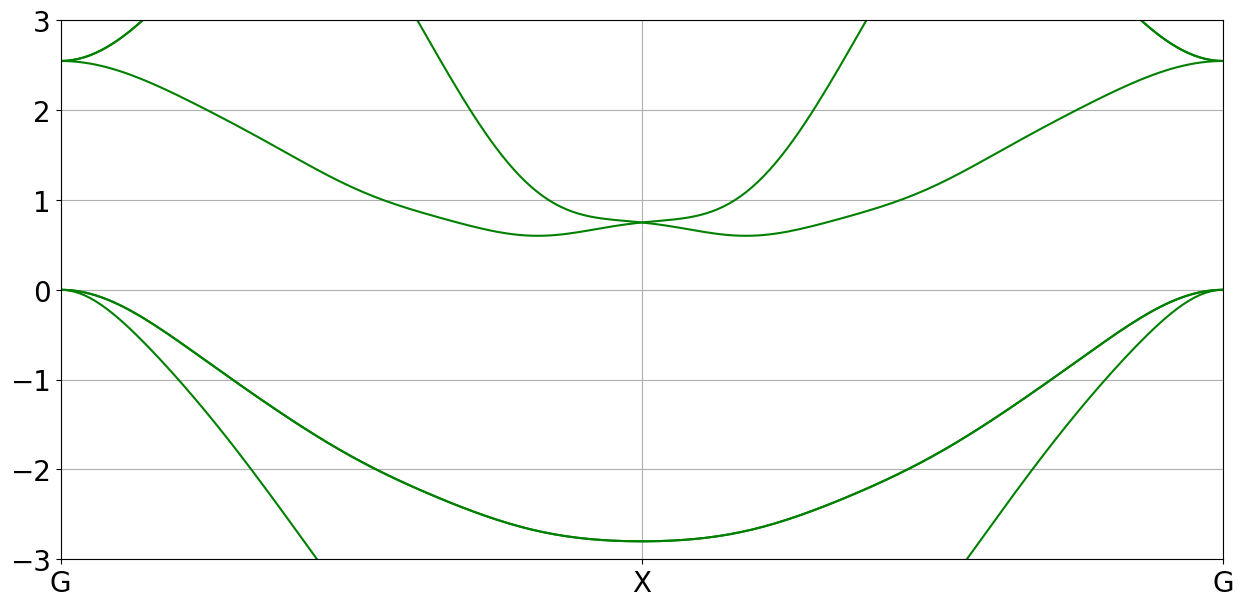

In [103]:
fig,ax=plt.subplots(figsize=[15,7])
plt.plot(w90_qe.get_bands()-max(w90_qe.get_bands()[:,b-1]),'-',color='green',label = 'DFT')
plt.ylim(-3,3)

plt.grid()
plt.xticks(l_x,l_names)
plt.tick_params(axis='both',labelsize=20)
plt.xlim(0,max(l_x))
#plt.ylim(-2,5)
#plt.legend()

#plt.savefig('plot_.pdf')